In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir('./data'))

['.DS_Store', 'example.csv', 'test.csv', 'correct_submission.csv', 'train.csv', 'features.csv', 'sample_submission.csv', 'stores.csv']


## 1. Loading and exploring input

### 1.1 Training data

In [3]:
train = pd.read_csv("./data/train.csv", sep=',')
train

,Store,Dept,Date,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,False,24924.50
1,1,1,2010-02-12,True,46039.49
2,1,1,2010-02-19,False,41595.55
3,1,1,2010-02-26,False,19403.54
4,1,1,2010-03-05,False,21827.90
...,...,...,...,...,...
419457,45,98,2012-09-28,False,508.37
419458,45,98,2012-10-05,False,628.10
419459,45,98,2012-10-12,False,1061.02
419460,45,98,2012-10-19,False,760.01


In [4]:
train.shape

(419462, 5)

In [5]:
train.describe()

,Store,Dept,Weekly_Sales
count,419462.000000,419462.000000,419462.000000
mean,22.200485,44.263161,15981.674527
std,12.785297,30.492077,22707.359392
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2078.657500
50%,22.000000,37.000000,7609.985000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [6]:
train.isnull().sum().sort_values(ascending=False) # no missing values

Weekly_Sales    0
IsHoliday       0
Date            0
Dept            0
Store           0
dtype: int64

### 1.2 Feature data

In [7]:
features = pd.read_csv("./data/features.csv", sep=",")
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
features.shape

(8190, 12)

In [9]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [10]:
features_missing_count = features.isnull().sum()
# isnull().sum() give the column-wise sum of missing values
features_missing_percentage = features.isnull().sum() * 100 / len(features)
features_data_type = features.dtypes

feature_summary = pd.DataFrame({"Missing_count": features_missing_count, 
                                "Missing_percentage": features_missing_percentage.round(2),
                                "Data_type": features_data_type})

feature_summary

,Missing_count,Missing_percentage,Data_type
Store,0,0.00,int64
Date,0,0.00,object
Temperature,0,0.00,float64
Fuel_Price,0,0.00,float64
MarkDown1,4158,50.77,float64
MarkDown2,5269,64.33,float64
MarkDown3,4577,55.89,float64
MarkDown4,4726,57.70,float64
MarkDown5,4140,50.55,float64
CPI,585,7.14,float64


### 1.3 Store data

In [11]:
stores = pd.read_csv("./data/stores.csv", sep=",")
stores.head().append(stores.tail())

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [12]:
print("Shape of store: ", stores.shape)

Shape of store:  (45, 3)


In [13]:
# check missing value
stores.isnull().sum().sort_values(ascending=False)

Size     0
Type     0
Store    0
dtype: int64

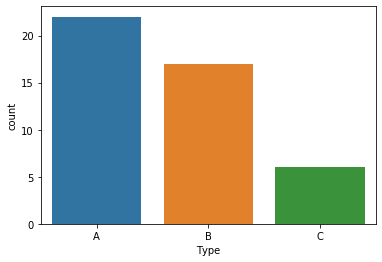

In [14]:
# store number for each type
sns.countplot(x='Type', data=stores)

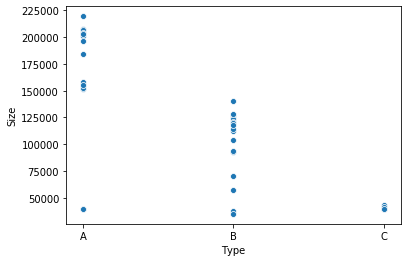

In [15]:
# how store type related with size
sns.scatterplot(x='Type', y='Size', data=stores)

### 1.4 test data

In [16]:
test = pd.read_csv("./data/test.csv", sep=',')
test.head()

,Store,Dept,Date,IsHoliday
0,1,2,2011-06-17,False
1,1,2,2012-04-06,False
2,1,2,2012-08-24,False
3,1,4,2010-04-02,False
4,1,5,2011-08-05,False


## 2. Joining tables

In [17]:
# make date type consistent
train['Date'] = pd.to_datetime(train['Date'], format="%Y-%m-%d")
features['Date'] = pd.to_datetime(features['Date'], format="%Y-%m-%d")
combined_train = train.merge(stores, on='Store').merge(features.drop('IsHoliday', axis=1), on=['Store', 'Date'])

test['Date'] = pd.to_datetime(test['Date'], format="%Y-%m-%d")
combined_test = test.merge(stores, on='Store').merge(features.drop('IsHoliday', axis=1), on=['Store', 'Date'])

In [18]:
combined_train.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,False,24924.50,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,False,50605.27,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,False,13740.12,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,False,39954.04,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,False,32229.38,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [19]:
combined_train.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,419462.000000,419462.000000,419462.000000,419462.000000,419462.000000,419462.000000,149973.000000,110720.000000,136442.000000,134334.000000,150721.000000,419462.000000,419462.000000
mean,22.200485,44.263161,15981.674527,136728.088385,60.090161,3.361105,7246.281879,3331.401285,1433.151853,3382.710107,4627.820970,171.202702,7.960171
std,12.785297,30.492077,22707.359392,60980.634943,18.446943,0.458544,8288.241100,9468.651452,9592.186021,6289.456396,5959.167476,39.159150,1.863313
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2078.657500,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7609.985000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5556.150000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [20]:
combined_train_missing_count = combined_train.isnull().sum()
combined_train_missing_count

Store                0
Dept                 0
Date                 0
IsHoliday            0
Weekly_Sales         0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       269489
MarkDown2       308742
MarkDown3       283020
MarkDown4       285128
MarkDown5       268741
CPI                  0
Unemployment         0
dtype: int64

In [21]:
combined_test.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2,2011-06-17,False,A,151315,86.41,3.637,NaN,NaN,NaN,NaN,NaN,214.998060,7.682
1,1,2,2012-04-06,False,A,151315,70.43,3.891,10121.97,NaN,77.98,3750.59,4510.72,221.435611,7.143
2,1,2,2012-08-24,False,A,151315,77.66,3.620,6237.83,260.06,2.97,3463.03,7988.25,222.171946,6.908
3,1,4,2010-04-02,False,A,151315,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808
4,1,51,2010-04-02,False,A,151315,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808


## 3. Data inspecting

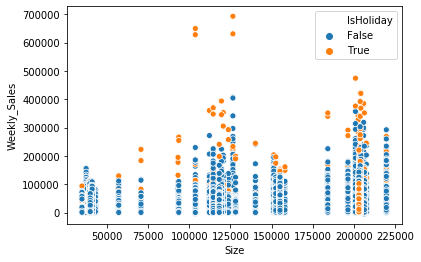

In [22]:
# plot
import seaborn as sns
sns.scatterplot(x='Size', y='Weekly_Sales', data=combined_train, hue='IsHoliday')

In [23]:
# Is dept necessary?
grouped = combined_train.groupby(['Dept', 'Date']).mean().round(0).reset_index() # disgarding stores
data = grouped[['Dept', 'Date', 'Weekly_Sales']]
data

,Dept,Date,Weekly_Sales
0,1,2010-02-05,19596.0
1,1,2010-02-12,32291.0
2,1,2010-02-19,25008.0
3,1,2010-02-26,15142.0
4,1,2010-03-05,16948.0
...,...,...,...
11084,99,2012-09-28,0.0
11085,99,2012-10-05,527.0
11086,99,2012-10-12,96.0
11087,99,2012-10-19,0.0


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


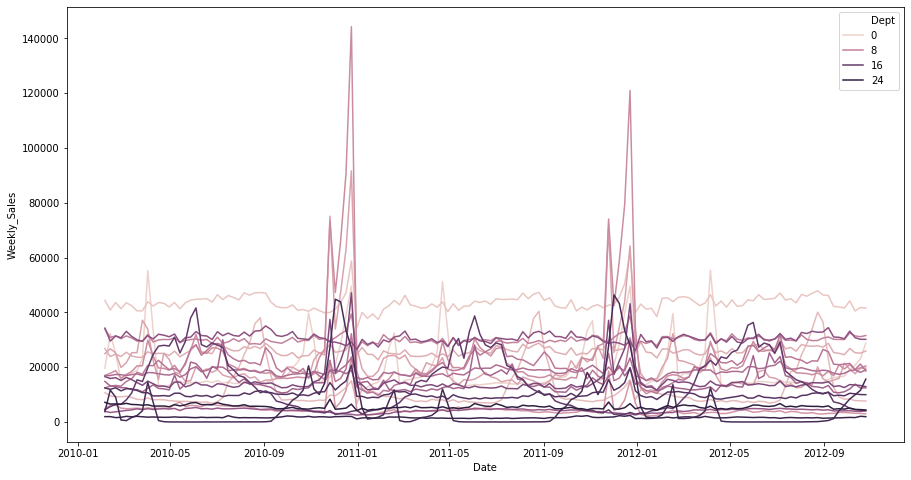

In [24]:
data_1 = data.loc[data['Dept'] <= 20]
plt.figure(figsize=(15,8))
sns.lineplot('Date', 'Weekly_Sales', hue='Dept', data = data_1)

In [25]:
grouped = combined_train[['Store', 'Date', 'Weekly_Sales']]
grouped['Month'] = grouped['Date'].map(lambda x: x.strftime('%m-%d'))
grouped['Month'] = pd.to_datetime(grouped['Month'], format="%m-%d")
grouped = grouped.groupby(['Store', 'Month']).mean().round(0).reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


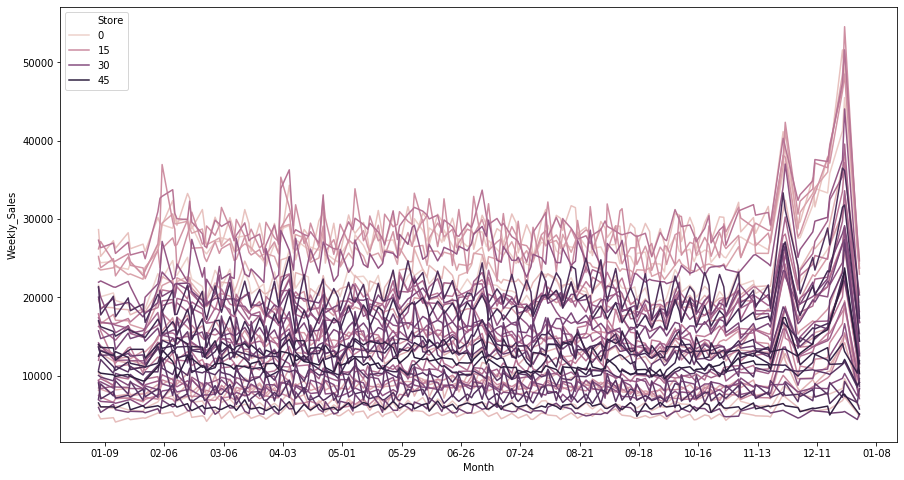

In [26]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

plt.figure(figsize=(15,8))
g = sns.lineplot('Month', 'Weekly_Sales', hue='Store', data = grouped)

g.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
g.xaxis.set_major_formatter(DateFormatter("%m-%d"))

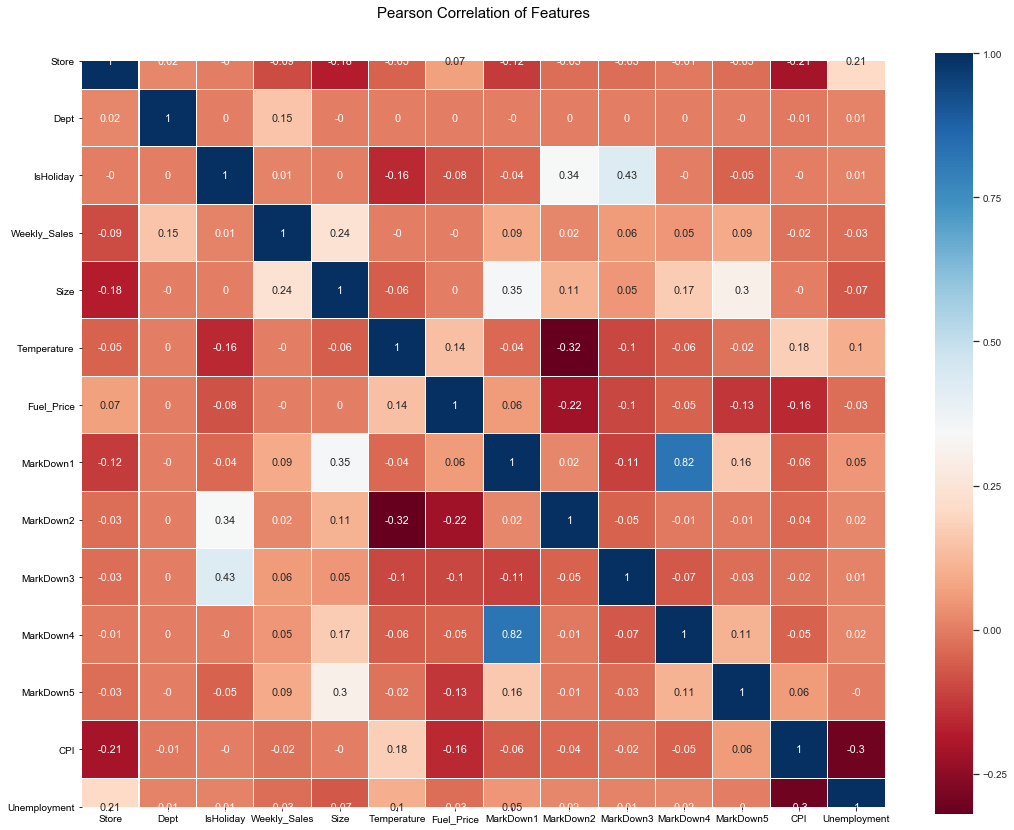

In [27]:
# corelation analysis
colormap = plt.cm.RdBu
corr = combined_train.corr()

plt.figure(figsize=(18, 14))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=0.9)
sns.heatmap(round(corr,2),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

## 4. Data pre-processing

### 4.1 Replace missing markdown values by 0

In [28]:
# replace NaN
combined_train.fillna(0,inplace=True)
combined_test.fillna(0,inplace=True)

In [29]:
combined_train['Year'] = pd.DatetimeIndex(combined_train['Date']).year
combined_train['Month'] = pd.DatetimeIndex(combined_train['Date']).month

combined_test['Year'] = pd.DatetimeIndex(combined_test['Date']).year
combined_test['Month'] = pd.DatetimeIndex(combined_test['Date']).month

In [30]:
combined_train.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month
0,1,1,2010-02-05,False,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
1,1,2,2010-02-05,False,50605.27,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
2,1,3,2010-02-05,False,13740.12,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
3,1,4,2010-02-05,False,39954.04,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
4,1,5,2010-02-05,False,32229.38,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2


### 4.2 Perform one-hot for categorical and boolean values

In [31]:
combined_train['IsHoliday'] = combined_train['IsHoliday'].apply(lambda x: 1 if x==True else 0)
combined_test['IsHoliday'] = combined_test['IsHoliday'].apply(lambda x: 1 if x==True else 0)

In [32]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
combined_train['Type'] = encoder.fit_transform(combined_train['Type'])
combined_test['Type'] = encoder.fit_transform(combined_test['Type'])

In [33]:
combined_train.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month
0,1,1,2010-02-05,0,24924.50,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
1,1,2,2010-02-05,0,50605.27,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
2,1,3,2010-02-05,0,13740.12,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
3,1,4,2010-02-05,0,39954.04,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
4,1,5,2010-02-05,0,32229.38,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2


In [34]:
combined_test.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month
0,1,2,2011-06-17,0,0,151315,86.41,3.637,0.00,0.00,0.00,0.00,0.00,214.998060,7.682,2011,6
1,1,2,2012-04-06,0,0,151315,70.43,3.891,10121.97,0.00,77.98,3750.59,4510.72,221.435611,7.143,2012,4
2,1,2,2012-08-24,0,0,151315,77.66,3.620,6237.83,260.06,2.97,3463.03,7988.25,222.171946,6.908,2012,8
3,1,4,2010-04-02,0,0,151315,62.27,2.719,0.00,0.00,0.00,0.00,0.00,210.820450,7.808,2010,4
4,1,51,2010-04-02,0,0,151315,62.27,2.719,0.00,0.00,0.00,0.00,0.00,210.820450,7.808,2010,4


### 4.3 Outliner

In [35]:
# z-score: normal distribution
combined_train_no_neg = combined_train[combined_train['Weekly_Sales'] >= 0]

combined_train_no_neg.head()
print(combined_train.shape)
print(combined_train.columns)


(419462, 18)
Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Weekly_Sales', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month'],
      dtype='object')


In [36]:
outliner_train = combined_train[['Store', 'Dept', 'Date', 'Weekly_Sales']]
outliner_train

,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,24924.50
1,1,2,2010-02-05,50605.27
2,1,3,2010-02-05,13740.12
3,1,4,2010-02-05,39954.04
4,1,5,2010-02-05,32229.38
...,...,...,...,...
419457,45,93,2010-12-03,2117.26
419458,45,94,2010-12-03,4022.27
419459,45,95,2010-12-03,44928.96
419460,45,97,2010-12-03,5996.74


In [37]:
outliner_train_no_neg = outliner_train[outliner_train['Weekly_Sales'] >= 0]
outliner_train_no_neg.head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,24924.50
1,1,2,2010-02-05,50605.27
2,1,3,2010-02-05,13740.12
3,1,4,2010-02-05,39954.04
4,1,5,2010-02-05,32229.38


In [38]:
combined_train.drop('Weekly_Sales', axis=1, inplace=True)
combined_train_no_neg.drop('Weekly_Sales', axis=1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
print(combined_train.shape)
print(combined_train_no_neg.shape)

(419462, 17)
(418184, 17)


In [40]:
outliner_train.head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,24924.50
1,1,2,2010-02-05,50605.27
2,1,3,2010-02-05,13740.12
3,1,4,2010-02-05,39954.04
4,1,5,2010-02-05,32229.38


In [41]:
from scipy.stats import zscore

outliner_train['outliner'] = np.where((zscore(outliner_train['Weekly_Sales']) <= -2.5) | (zscore(outliner_train['Weekly_Sales']) >= 2.5), 1, 0)
num_outliners = outliner_train[outliner_train['outliner'] == 1]['Weekly_Sales'].count()

print('Number of `Weekly_Sales` outliners: {}\nPercent outliners: {:.2f}%'.format(num_outliners, num_outliners / combined_train.shape[0] * 100))

Number of `Weekly_Sales` outliners: 13699
Percent outliners: 3.27%


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
num_neg_sales = outliner_train[outliner_train['Weekly_Sales'] < 0].shape[0]
print('Number of negative `Weekly_Sales` : {}\nPercent: {:.2f}%'.format(num_neg_sales, num_neg_sales / outliner_train.shape[0] * 100))

Number of negative `Weekly_Sales` : 1278
Percent: 0.30%


In [43]:
outliner_train_no_neg['Weekly_Sales_Log'] = np.log1p(outliner_train_no_neg['Weekly_Sales'])
outliner_train_no_neg['outliner'] = np.where((zscore(outliner_train_no_neg['Weekly_Sales_Log']) <= -2.5) | (zscore(outliner_train_no_neg['Weekly_Sales_Log']) >= 2.5), 1, 0)
num_outliners = outliner_train_no_neg[outliner_train_no_neg['outliner'] == 1]['Weekly_Sales_Log'].count()

print('Number of `Weekly_Sales_Log` outliners: {}\nPercent outliners: {:.2f}%'.format(num_outliners, num_outliners / outliner_train.shape[0] * 100))

Number of `Weekly_Sales_Log` outliners: 13278
Percent outliners: 3.17%


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
## QuantileTransformer ##
## skewed
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')
outliner_train_qt = outliner_train.copy()
outliner_train_qt['Weekly_Sales'] = qt.fit_transform(np.array(outliner_train_qt['Weekly_Sales'] + 1).reshape(-1, 1))
outliner_train_qt['outliner'] = np.where((zscore(outliner_train_qt['Weekly_Sales']) <= -2.5) | (zscore(outliner_train_qt['Weekly_Sales']) >= 2.5), 1, 0)
num_outliners = outliner_train_qt[outliner_train_qt['outliner'] == 1]['Weekly_Sales'].count()

print('QuantileTransformer - Number of `Weekly_Sales` outliners: {}\nPercent outliners: {:.2f}%'.format(num_outliners, num_outliners / outliner_train.shape[0] * 100))

QuantileTransformer - Number of `Weekly_Sales` outliners: 5361
Percent outliners: 1.28%


In [45]:
outliner_train_no_neg

,Store,Dept,Date,Weekly_Sales,Weekly_Sales_Log,outliner
0,1,1,2010-02-05,24924.50,10.123647,0
1,1,2,2010-02-05,50605.27,10.831831,0
2,1,3,2010-02-05,13740.12,9.528148,0
3,1,4,2010-02-05,39954.04,10.595510,0
4,1,5,2010-02-05,32229.38,10.380665,0
...,...,...,...,...,...,...
419457,45,93,2010-12-03,2117.26,7.658350,0
419458,45,94,2010-12-03,4022.27,8.299850,0
419459,45,95,2010-12-03,44928.96,10.712860,0
419460,45,97,2010-12-03,5996.74,8.699138,0


In [46]:
# drop outliners
outliner_train_tf = outliner_train[outliner_train['outliner'] != 1]
outliner_train_no_neg_tf = outliner_train_no_neg[outliner_train_no_neg['outliner'] != 1]
outliner_train_qt_tf = outliner_train_qt[outliner_train_qt['outliner'] != 1]
train_tf = combined_train_no_neg.loc[outliner_train_qt_tf.index].reset_index(drop=True)

In [47]:
train_tf.shape

(414101, 17)

In [48]:
train_tf.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month
0,1,1,2010-02-05,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
1,1,2,2010-02-05,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
2,1,3,2010-02-05,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
3,1,4,2010-02-05,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2
4,1,5,2010-02-05,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2


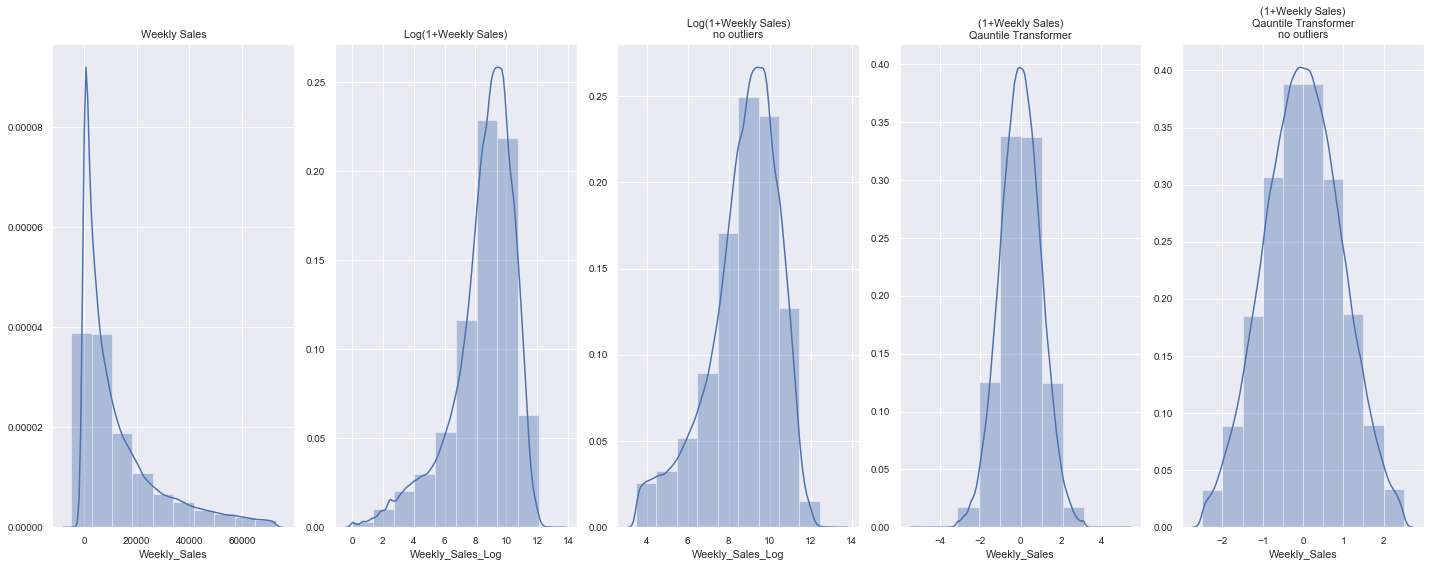

In [49]:
fig, axes = plt.subplots(ncols=5, figsize=(20,8))
sns.distplot(outliner_train_tf['Weekly_Sales'], bins=10, ax=axes[0]).set_title('Weekly Sales')
sns.distplot(outliner_train_no_neg['Weekly_Sales_Log'], bins=10, ax=axes[1]).set_title('Log(1+Weekly Sales)')
sns.distplot(outliner_train_no_neg_tf['Weekly_Sales_Log'], bins=10, ax=axes[2]).set_title('Log(1+Weekly Sales)\nno outliers')
sns.distplot(outliner_train_qt['Weekly_Sales'], bins=10, ax=axes[3]).set_title('(1+Weekly Sales)\nQauntile Transformer')
sns.distplot(outliner_train_qt_tf['Weekly_Sales'], bins=10, ax=axes[4]).set_title('(1+Weekly Sales)\nQauntile Transformer\nno outliers')

plt.tight_layout()

In [50]:
outliner_train_qt_tf.drop(['outliner'], axis=1, inplace=True)
outliner_train_qt_tf.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,0.829125
1,1,2,2010-02-05,1.440383
2,1,3,2010-02-05,0.387304
3,1,4,2010-02-05,1.212979
4,1,5,2010-02-05,1.027415


## 5. Model

In [51]:
from sklearn.metrics import mean_absolute_error, make_scorer

# def mae_custom(y_true, y_pred):
#     return mean_absolute_error(y_true, y_pred) * 0.01

# mae = make_scorer(mae_custom)
def weighted_mae_custom(y_true, y_pred):
    '''
    Custom weighting function as specified in the evaluation section.
    '''
    weights = combined_train['IsHoliday']
    sample_weights = pd.Series(weights.loc[y_true.index.values].values.reshape(-1)).dropna()
    return (1.0 / np.sum(sample_weights)) * np.sum(sample_weights * np.abs(y_true - y_pred)) * 0.01

weighted_mae = make_scorer(weighted_mae_custom)

In [52]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

params={'rf': {
            'n_estimators': [100, 250, 500],
            'max_depth': [1, 2, 3, 4],
            'max_features': [2, 4, 6, 8]
            },
        'knn': {
            'n_neighbors': [2, 3, 4],  
            'p': [1,2],
            },
        'gb': {
            'max_depth': [1, 2, 3, 4],
            'learning_rate':[1e-3,1e-2,0.1,1]
            },
        'lr':{
            'fit_intercept': [True, False]
            },
        'lgbm':{
            'learning_rate':[1e-3,1e-2,0.1,1],
            'n_estimators': [100, 250, 500],
            },
        'xgb':{
            
            },
        }

models = {
          'lr': LinearRegression(n_jobs=-1),
          'knn': KNeighborsRegressor(n_jobs=-1),
          'rf': RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=100),
          'gb': GradientBoostingRegressor(random_state=0),
          'lgbm': LGBMRegressor(random_state=0),
          'xgb': XGBRegressor(nthread=-1, seed=0),
         }

best_params = {}
best_models = []

for name, model in models.items():
    cv1 = RepeatedKFold(n_splits=2, n_repeats=1,  random_state=0)                       
    gs_cv = RandomizedSearchCV(model, 
                         params[name], 
                         scoring=weighted_mae,
                         cv=cv1,
                         n_jobs=-1,
                         iid=True,
                         verbose=2)
    
    gs_cv.fit(train_tf.drop('Date', axis=1), outliner_train_qt_tf['Weekly_Sales'])
    
    mean = abs(gs_cv.cv_results_['mean_test_score'][0])
    std = gs_cv.cv_results_['std_test_score'][0]
    
    best_params[name] = gs_cv.best_params_
    best_models.append(gs_cv.best_estimator_)
    
    print("Results for {}: {:.4f} ({:.4f}) [{:.4f}, {:.4f}] WMAE".format(name, 
                                                                         mean,
                                                                         std,
                                                                         mean - std,
                                                                         mean + std))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using bac

Results for lr: 0.0035 (0.0000) [0.0035, 0.0035] WMAE
Fitting 2 folds for each of 6 candidates, totalling 12 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  5.0min remaining: 15.0min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  5.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.1min finished


Results for knn: 0.0029 (0.0000) [0.0029, 0.0030] WMAE
Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   53.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min finished


Results for rf: 0.0032 (0.0000) [0.0032, 0.0032] WMAE
Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   49.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished


Results for gb: 0.0029 (0.0000) [0.0029, 0.0029] WMAE
Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   13.0s remaining:   19.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   43.6s finished


Results for lgbm: 0.0007 (0.0000) [0.0007, 0.0007] WMAE
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.9s finished
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[01:07:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Results for xgb: 0.0019 (0.0000) [0.0019, 0.0019] WMAE


In [53]:
best_models[4]

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.001, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
train_tf.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month'],
      dtype='object')

In [55]:
combined_test.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month'],
      dtype='object')

In [56]:
combined_test['Weekly_Sales'] = qt.inverse_transform(best_models[4].predict(combined_test.drop('Date', axis=1)).reshape(-1, 1)) + 1
combined_test[0:50]

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Weekly_Sales
0,1,2,2011-06-17,0,0,151315,86.41,3.637,0.00,0.00,0.00,0.00,0.00,214.998060,7.682,2011,6,8600.260701
1,1,2,2012-04-06,0,0,151315,70.43,3.891,10121.97,0.00,77.98,3750.59,4510.72,221.435611,7.143,2012,4,8600.260701
2,1,2,2012-08-24,0,0,151315,77.66,3.620,6237.83,260.06,2.97,3463.03,7988.25,222.171946,6.908,2012,8,8600.260701
3,1,4,2010-04-02,0,0,151315,62.27,2.719,0.00,0.00,0.00,0.00,0.00,210.820450,7.808,2010,4,8397.375780
4,1,51,2010-04-02,0,0,151315,62.27,2.719,0.00,0.00,0.00,0.00,0.00,210.820450,7.808,2010,4,6859.935229
5,1,5,2011-08-05,0,0,151315,91.65,3.684,0.00,0.00,0.00,0.00,0.00,215.544618,7.962,2011,8,8397.375780
6,1,5,2011-11-25,1,0,151315,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,2011,11,8397.375780
7,1,17,2011-11-25,1,0,151315,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,2011,11,7791.540877
8,1,92,2011-11-25,1,0,151315,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,2011,11,9758.924111
9,1,6,2010-08-27,0,0,151315,85.22,2.619,0.00,0.00,0.00,0.00,0.00,211.567306,7.787,2010,8,8397.375780


In [57]:
combined_test = combined_test.sort_values(by=['Store', 'Dept'])
combined_test.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Weekly_Sales
0,1,2,2011-06-17,0,0,151315,86.41,3.637,0.00,0.00,0.00,0.00,0.00,214.998060,7.682,2011,6,8600.260701
1,1,2,2012-04-06,0,0,151315,70.43,3.891,10121.97,0.00,77.98,3750.59,4510.72,221.435611,7.143,2012,4,8600.260701
2,1,2,2012-08-24,0,0,151315,77.66,3.620,6237.83,260.06,2.97,3463.03,7988.25,222.171946,6.908,2012,8,8600.260701
3,1,4,2010-04-02,0,0,151315,62.27,2.719,0.00,0.00,0.00,0.00,0.00,210.820450,7.808,2010,4,8397.375780
5,1,5,2011-08-05,0,0,151315,91.65,3.684,0.00,0.00,0.00,0.00,0.00,215.544618,7.962,2011,8,8397.375780


In [58]:
pred = pd.DataFrame(columns=['Id', 'Weekly_Sales'])
pred['Id'] = combined_test['Store'].astype(str) + '_' + combined_test['Dept'].astype(str) + '_' + combined_test['Date'].astype(str)
pred['Weekly_Sales'] = combined_test['Weekly_Sales']
pred[0:50]

,Id,Weekly_Sales
0,1_2_2011-06-17,8600.260701
1,1_2_2012-04-06,8600.260701
2,1_2_2012-08-24,8600.260701
3,1_4_2010-04-02,8397.375780
5,1_5_2011-08-05,8397.375780
6,1_5_2011-11-25,8397.375780
9,1_6_2010-08-27,8397.375780
10,1_6_2010-12-31,8397.375780
12,1_7_2012-07-27,8397.375780
14,1_8_2011-07-29,8397.375780


In [59]:
pred.to_csv('submission.csv', index=False)

In [60]:
submission = pd.read_csv("./data/final_submission.csv", sep=',')
print(submission.shape)

FileNotFoundError: [Errno 2] File b'./data/final_submission.csv' does not exist: b'./data/final_submission.csv'

In [ ]:
sample = pd.read_csv("./data/sample_submission.csv", sep=',')
print(submission.shape)